# Dom's Notebook

hypothesis:

(01/09/20)
- Taxo ID [7,8] fall into Exec and consult
- taxo ID [3,4,5,9] fall into specialists
- Taxo ID [1,2,6] are further divided by experience level
        - we weren't satisfied on the results of this grouping

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../')
import wrangle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import minmax_scale, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import classification_report, accuracy_score
from scipy.stats import ttest_ind


In [2]:
data = pd.read_excel('/Users/dom/codeup_data_science/capstone/kev/survey_responses.xlsx', )
data.head(2)

,q00,q01a,q01b,q01c,q02a,q02b,q02c,q02d,q02e,q02f,...,q14,q15,q16,q17a,q17b,q18a,q21,q22,q23,q09a
0,284,Academic,4,1.0,Often,Neutral,Never,Often,Often,Often,...,NaN,NaN,"CHI, INTERACT",depending on the professional values,7.0,"any, depending on the values",research-practice connections,NaN,research-practice connections,"sort of, psychology background."
1,288,Academic,4,1.0,Occasionally,Neutral,Occasionally,Often,Often,Often,...,"Content, cost, timing (can I get away at this ...","Dagstuhl workshop - small, intense, intimate g...",Hawaii international conference on Education,I would attend any of these,6.0,Multi-track: Every attendee chooses their own ...,NaN,NaN,Don’t create schedule conflicts with other rel...,"Yes, I was taught how to conduct research"


In [3]:
data_dictionary = pd.read_excel('../data_files/data_dictionary.xlsx')
data_dictionary.head()

,qid,column_name,is_required,from_orig_file,in_wrangle,char_type,function,data_type,encoder,survey_section,question_group,question_text
0,q00,resp_id,True,True,True,numeric,identification,int64,NaN,Survey,ID,Entry Id
1,q01a,job_title,True,True,True,text,categorical,category,NaN,Work,Position,Title
2,q01b,job_taxo,True,True,True,numeric,categorical,category,NaN,Work,Position,Job Taxo ID
3,q01c,job_id,False,True,True,numeric,categorical,category,NaN,Work,Position,Job ID
4,q02a,job_conduct_res,True,True,True,numeric,quantitative,int64,often5,Work,Research Duties,Conducting Research


In [4]:
data.rename(columns = data_dictionary[['qid','column_name']].set_index('qid').column_name, inplace=True)
data.head(2)

,resp_id,job_title,job_taxo,job_id,job_conduct_res,job_analyze_res,job_buy_res_report,job_manage_res_proj,job_observe_res,job_plan_res,...,how_pick_events,best_event,events_attend_recent,ideal_conference_size,ideal_conference_size_cat_orig,ideal_structure,ideal_topics,ideal_attendees,recommendations,research_educ
0,284,Academic,4,1.0,Often,Neutral,Never,Often,Often,Often,...,NaN,NaN,"CHI, INTERACT",depending on the professional values,7.0,"any, depending on the values",research-practice connections,NaN,research-practice connections,"sort of, psychology background."
1,288,Academic,4,1.0,Occasionally,Neutral,Occasionally,Often,Often,Often,...,"Content, cost, timing (can I get away at this ...","Dagstuhl workshop - small, intense, intimate g...",Hawaii international conference on Education,I would attend any of these,6.0,Multi-track: Every attendee chooses their own ...,NaN,NaN,Don’t create schedule conflicts with other rel...,"Yes, I was taught how to conduct research"


In [5]:
df,_ = wrangle.wrangle_data()
df.head()

,job_title,job_taxo,job_id,job_conduct_res,job_analyze_res,job_buy_res_report,job_manage_res_proj,job_observe_res,job_plan_res,job_teach_res,...,session_workshop,session_network,session_social_event,session_qa,sesson_topic_tables,other_conference_types,ideal_topics,ideal_attendees,recommendations,persona_id
resp_id,,,,,,,,,,,,,,,,,,,,,
284,Academic,4,1.0,3,2,0,3,3,3,3,...,2,3,2,2,2,NaN,research-practice connections,NaN,research-practice connections,2
288,Academic,4,1.0,1,2,1,3,3,3,3,...,3,3,1,1,2,NaN,NaN,NaN,Don’t create schedule conflicts with other rel...,2
294,Academic,4,1.0,3,3,1,3,1,3,3,...,2,2,2,2,2,NaN,NaN,NaN,Looking forward! \n,2
281,Academic,4,1.0,3,4,0,2,3,2,0,...,3,2,2,3,2,NaN,"Research design, innovative methods, communica...",NaN,NaN,2
280,Academic,4,1.0,3,3,0,1,1,3,2,...,3,2,1,2,2,You should consider the combination of confere...,NaN,NaN,NaN,2


- Checking freds nlp functions

In [6]:
# sys.path.append('../fred')
# import nlp

In [7]:
# mat, vect = nlp.create_tfidf_matrix(df.best_event)

#### Exploration

In [8]:
#dataframe
df.head(2)

,job_title,job_taxo,job_id,job_conduct_res,job_analyze_res,job_buy_res_report,job_manage_res_proj,job_observe_res,job_plan_res,job_teach_res,...,session_workshop,session_network,session_social_event,session_qa,sesson_topic_tables,other_conference_types,ideal_topics,ideal_attendees,recommendations,persona_id
resp_id,,,,,,,,,,,,,,,,,,,,,
284,Academic,4,1.0,3,2,0,3,3,3,3,...,2,3,2,2,2,NaN,research-practice connections,NaN,research-practice connections,2
288,Academic,4,1.0,1,2,1,3,3,3,3,...,3,3,1,1,2,NaN,NaN,NaN,Don’t create schedule conflicts with other rel...,2


In [9]:
#Quantitative columns
quant_cols = df.select_dtypes([int,float]).columns
quant_cols.to_list()

['job_conduct_res',
 'job_analyze_res',
 'job_buy_res_report',
 'job_manage_res_proj',
 'job_observe_res',
 'job_plan_res',
 'job_teach_res',
 'job_advocate_res',
 'job_hire_res_vendor',
 'job_lead_res_team',
 'exp_conduct_res',
 'exp_analyze_res',
 'exp_buy_res_report',
 'exp_manage_res_proj',
 'exp_observe_res',
 'exp_plan_res',
 'exp_teach_res',
 'exp_advocate_res',
 'exp_hire_res_vendor',
 'exp_lead_res_team',
 'learning_talks',
 'learning_read',
 'learning_meetup',
 'learning_workshop',
 'learning_conference',
 'likely_watch_video',
 'likely_internet',
 'likely_book',
 'likely_online_group',
 'likely_colleague',
 'likely_meetup',
 'likely_conference',
 'likely_workshop',
 'factor_speaker',
 'factor_diverse_speak',
 'factor_topics',
 'factor_format_sessions',
 'factor_size',
 'factor_network',
 'factor_variety_attend',
 'factor_code',
 'factor_location',
 'factor_ability_to_pay',
 'ideal_multi_track',
 'ideal_single_track',
 'ideal_unconference',
 'session_keynote',
 'session_long_

In [10]:
#Jobs by taxo id
    #1 is UX researchers
    #2 is Developers
    #3 is Researcher/Scientist
    #4 is Academic/Students
    #5 is Planners?
    #6 is Design/Research Managers
    #7 is Consultans
    #8 is Executive
    #9 is misc
data.groupby(['job_taxo', 'job_title']).job_title.count()

job_taxo  job_title              
1         Principal UX Researcher     44
          Senior UX Researcher        97
          UX Researcher              202
2         Principal UX Designer       28
          Senior UX Designer          25
          UX Designer                 87
3         Analyst                      5
          Anthropologist               3
          Behavioral economist         1
          Ethnographer                 1
          Market Researcher            4
          Research Scientist           1
          Researcher                   9
4         Academic                    23
          Student                      5
5         Content Strategist           4
          Engineer                    14
          Information Architect       11
          Product Manager             10
          Service Designer            10
          Strategist                  25
6         Design Manager              65
          Research Manager            70
7         Consultant   

In [11]:
df.groupby(['persona_id','job_taxo']).persona_id.count()

persona_id  job_taxo
1           7            49
            8            45
2           3            23
            4            23
            5            65
            9            12
3           1           125
            2            22
            6            87
4           1           113
            2            47
            6            21
5           1            49
            2            40
            6             5
Name: persona_id, dtype: int64

In [12]:
df.persona_id.value_counts()

3    234
4    181
2    123
5     94
1     94
Name: persona_id, dtype: int64

In [13]:
exp_cols = ['exp_conduct_res', 'exp_analyze_res',
           'exp_buy_res_report', 'exp_manage_res_proj', 'exp_observe_res',
           'exp_plan_res', 'exp_teach_res', 'exp_advocate_res',
           'exp_hire_res_vendor', 'exp_lead_res_team']
df[exp_cols].mean(axis = 1)

resp_id
284    5.0
288    4.7
294    3.6
281    0.6
280    2.0
      ... 
869    0.6
879    1.0
136    2.4
74     1.5
2      1.3
Length: 726, dtype: float64

In [14]:
#show distributions of values


In [70]:
#establish features and target and split train and test data
def assign_target(x):
    group=0
    if x.learning_conference > 1:
        group += 1
    if x.likely_conference > 0:
        group += 1
    return group
df['target'] = df.apply(assign_target, axis = 1)

x = quant_cols.drop(['likely_conference','learning_conference', 'likely_workshop','learning_workshop']).to_list()+['persona_id', 'job_taxo']
y = 'target'
train, test = train_test_split(df[x+[y]].dropna(subset = [y]), stratify = df[y])

In [71]:
#1/14/20
#use svm or 
#form hypothesis and test them
df.target.value_counts()

2    412
1    279
0     35
Name: target, dtype: int64

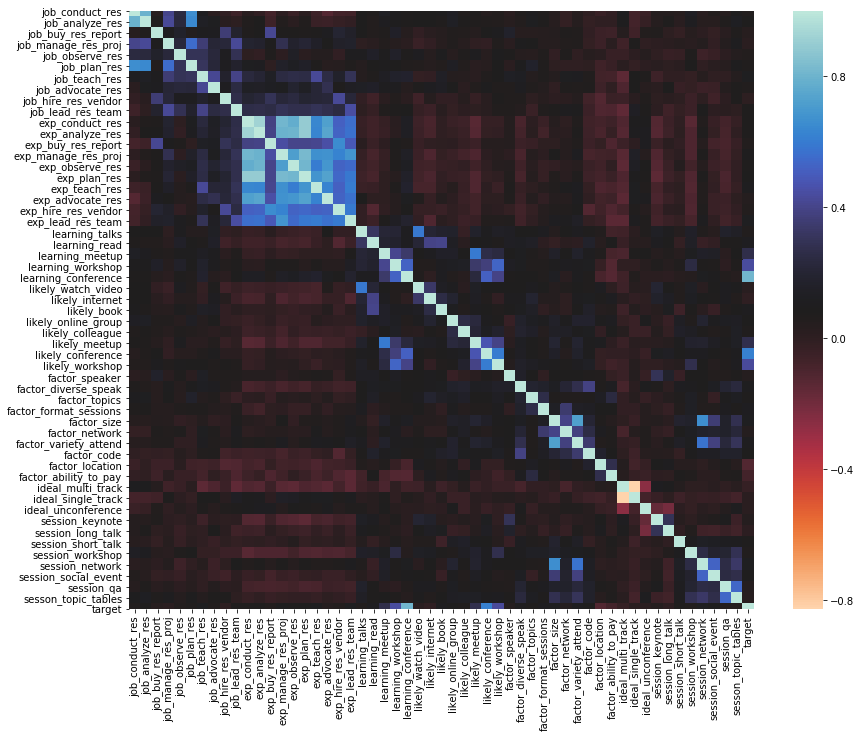

In [72]:
plt.figure(figsize=(14,11))
sns.heatmap(df.corr(), cmap = 'icefire_r')
plt.show()

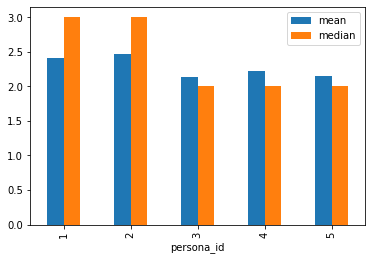

persona_id
1     94
2    123
3    234
4    181
5     94
Name: likely_conference, dtype: int64

In [73]:
df.groupby('persona_id').likely_conference.agg(['mean', 'median']).plot.bar()
plt.show()
df.groupby('persona_id').likely_conference.count()

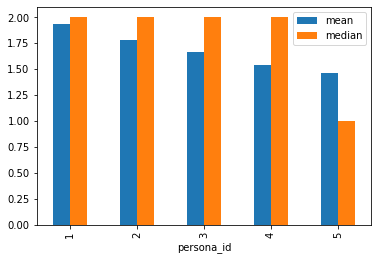

In [74]:
df.groupby('persona_id').learning_conference.agg(['mean', 'median']).plot.bar()
plt.show()


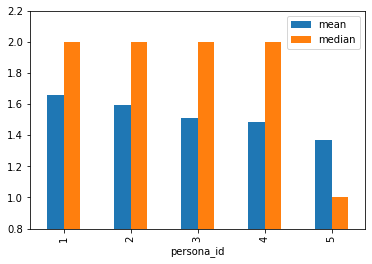

persona_id
1     94
2    123
3    234
4    181
5     94
Name: target, dtype: int64

In [75]:
df.groupby('persona_id').target.agg(['mean', 'median']).plot.bar()
plt.ylim(.8, 2.2)
plt.show()
df.groupby('persona_id').target.count()


Text(0.5, 1, 'Statistical difference between persona groups of likelyhood to attend a conference')

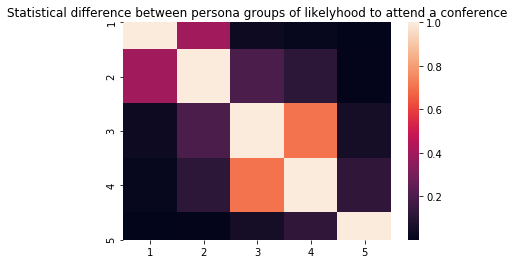

In [76]:
ttests = {}
row = {}
for i in range(1,6):
    for j in range(1,6):
        ttests[j] = ttest_ind(df[df.persona_id == i].target,df[(df.persona_id == j)].target, nan_policy='omit')[1]
    row[i] = ttests.copy()
sns.heatmap(pd.DataFrame(row))
plt.title('Statistical difference between persona groups of likelyhood to attend a conference')

In [77]:
pd.DataFrame(row)

,1,2,3,4,5
1,1.000000,0.401486,0.035281,0.019733,0.000594
2,0.401486,1.000000,0.197971,0.120233,0.005634
3,0.035281,0.197971,1.000000,0.703918,0.058427
4,0.019733,0.120233,0.703918,1.000000,0.126495
5,0.000594,0.005634,0.058427,0.126495,1.000000


In [78]:
tree = DecisionTreeClassifier(max_depth=4, max_features=20, random_state=123)
tree.fit(train[x], train[y])
predicted = tree.predict(test[x]) 


In [79]:
print(classification_report(test[y], predicted))
pd.crosstab(test[y], predicted)

              precision    recall  f1-score   support

           0       0.50      0.11      0.18         9
           1       0.50      0.27      0.35        70
           2       0.60      0.83      0.69       103

    accuracy                           0.58       182
   macro avg       0.53      0.40      0.41       182
weighted avg       0.56      0.58      0.54       182



col_0,0,1,2
target,,,
0,1,2,6
1,0,19,51
2,1,17,85


[Text(145.70000000000002, 195.696, 'session_network <= 0.5\ngini = 0.527\nsamples = 544\nvalue = [26, 209, 309]'),
 Text(55.800000000000004, 152.208, 'likely_internet <= 1.5\ngini = 0.565\nsamples = 47\nvalue = [6, 27, 14]'),
 Text(24.8, 108.72, 'likely_colleague <= 3.5\ngini = 0.444\nsamples = 3\nvalue = [2, 0, 1]'),
 Text(12.4, 65.232, 'gini = 0.0\nsamples = 2\nvalue = [2, 0, 0]'),
 Text(37.2, 65.232, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(86.8, 108.72, 'learning_talks <= 1.5\ngini = 0.528\nsamples = 44\nvalue = [4, 27, 13]'),
 Text(62.0, 65.232, 'factor_speaker <= 3.5\ngini = 0.357\nsamples = 14\nvalue = [2, 11, 1]'),
 Text(49.6, 21.744, 'gini = 0.272\nsamples = 13\nvalue = [1, 11, 1]'),
 Text(74.4, 21.744, 'gini = 0.0\nsamples = 1\nvalue = [1, 0, 0]'),
 Text(111.60000000000001, 65.232, 'factor_format_sessions <= 3.5\ngini = 0.551\nsamples = 30\nvalue = [2, 16, 12]'),
 Text(99.2, 21.744, 'gini = 0.575\nsamples = 23\nvalue = [2, 10, 11]'),
 Text(124.0, 21.744, 'gini = 0

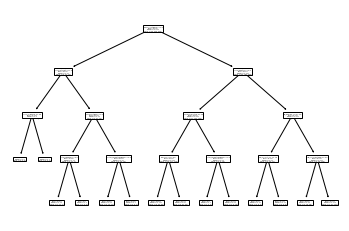

In [80]:
plot_tree(tree, feature_names=train[x].columns)

In [81]:
pd.DataFrame(tree.feature_importances_, index = train[x].columns)

,0
job_conduct_res,0.000000
job_analyze_res,0.085721
job_buy_res_report,0.000000
job_manage_res_proj,0.000000
job_observe_res,0.000000
job_plan_res,0.000000
job_teach_res,0.000000
job_advocate_res,0.000000
job_hire_res_vendor,0.000000
job_lead_res_team,0.063968


In [27]:
reg = SVC(random_state=123)
reg.fit(train[x], train[y])
predicted = reg.predict(test[x])
r2 = reg.score(test[x], test[y])

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [28]:
print(classification_report(test[y], predicted))
pd.crosstab(test[y], predicted)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.60      0.43      0.50        70
           2       0.66      0.84      0.74       103

    accuracy                           0.64       182
   macro avg       0.42      0.42      0.41       182
weighted avg       0.60      0.64      0.61       182



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


col_0,1,2
target,,
0,4,5
1,30,40
2,16,87


# MVP Model

In [42]:
df_mvp = df[['job_taxo', 'persona_id', 'num_employees']].join(pd.DataFrame(df[['exp_conduct_res']].apply(max, axis = 1), columns = ['experience']),).dropna()

In [43]:
#one hot encode for job taxos
df_mvp_ohe = pd.get_dummies(df_mvp, columns=['job_taxo']) 

In [44]:
x = df_mvp_ohe.drop(columns=['persona_id']).columns.to_list()
y = 'persona_id'
train, test = train_test_split(df_mvp_ohe, random_state = 123, stratify = df_mvp_ohe.persona_id)

In [45]:
classifier = SVC(random_state=123)
classifier.fit(train[x], train[y])
predicted = classifier.predict(test[x])

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [46]:
print(classification_report(test[y], predicted))
pd.crosstab(test[y], predicted)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        23
           2       1.00      1.00      1.00        31
           3       1.00      1.00      1.00        58
           4       1.00      1.00      1.00        45
           5       1.00      1.00      1.00        24

    accuracy                           1.00       181
   macro avg       1.00      1.00      1.00       181
weighted avg       1.00      1.00      1.00       181



col_0,1,2,3,4,5
persona_id,,,,,
1,23,0,0,0,0
2,0,31,0,0,0
3,0,0,58,0,0
4,0,0,0,45,0
5,0,0,0,0,24


In [47]:
tree = DecisionTreeClassifier(random_state=123)
tree.fit(train[x], train[y])
predicted = tree.predict(test[x]) 

In [48]:
print(classification_report(test[y], predicted))
pd.crosstab(test[y], predicted)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        23
           2       1.00      1.00      1.00        31
           3       1.00      1.00      1.00        58
           4       1.00      1.00      1.00        45
           5       1.00      1.00      1.00        24

    accuracy                           1.00       181
   macro avg       1.00      1.00      1.00       181
weighted avg       1.00      1.00      1.00       181



col_0,1,2,3,4,5
persona_id,,,,,
1,23,0,0,0,0
2,0,31,0,0,0
3,0,0,58,0,0
4,0,0,0,45,0
5,0,0,0,0,24


### Explore groups

In [36]:
df.groupby(['persona_id','job_title']).job_taxo.count()

persona_id  job_title              
1           Consultant                 49
            Executive                  45
2           Academic                   20
            Analyst                     5
            Anthropologist              3
            Author                      1
            Behavioral economist        1
            Content Strategist          4
            Engineer                   13
            Ethnographer                1
            Information Architect      10
            Intern                      5
            Market Researcher           3
            Operations                  5
            Product Manager             7
            Research Scientist          1
            Researcher                  9
            Service Designer           10
            Strategist                 21
            Student                     3
            Writer                      1
3           Design Manager             38
            Principal UX Designer       

In [37]:
df.groupby(['persona_id','num_employees'], ).job_taxo.count()

persona_id  num_employees
1           0.0               62
            1.0                6
            2.0                9
            3.0                1
            4.0               15
2           0.0               31
            1.0               14
            2.0               20
            3.0               10
            4.0               47
3           0.0               35
            1.0               18
            2.0               24
            3.0               20
            4.0              136
4           0.0               15
            1.0               17
            2.0               30
            3.0               19
            4.0              100
5           0.0               14
            1.0               15
            2.0               14
            3.0               10
            4.0               41
Name: job_taxo, dtype: int64

In [38]:
df.groupby(['persona_id','session_network']).job_taxo.count()

persona_id  session_network
1           0                   7
            1                  15
            2                  16
            3                  23
            4                  33
2           0                  12
            1                  28
            2                  31
            3                  33
            4                  19
3           0                  26
            1                  48
            2                  56
            3                  73
            4                  31
4           0                  14
            1                  55
            2                  51
            3                  47
            4                  14
5           0                   9
            1                  21
            2                  24
            3                  21
            4                  19
Name: job_taxo, dtype: int64

In [39]:
df.groupby(['persona_id','factor_speaker']).job_taxo.count()

persona_id  factor_speaker
1           0                  7
            1                 20
            2                 16
            3                 39
            4                 12
2           0                  8
            1                 33
            2                 19
            3                 45
            4                 18
3           0                 18
            1                 48
            2                 47
            3                 99
            4                 22
4           0                 14
            1                 43
            2                 38
            3                 64
            4                 22
5           0                  7
            1                 26
            2                 20
            3                 27
            4                 14
Name: job_taxo, dtype: int64

In [40]:
df.groupby(['persona_id','factor_diverse_speak']).job_title.count()

persona_id  factor_diverse_speak
1           0                         5
            1                         9
            2                        15
            3                        38
            4                        27
2           0                         7
            1                        14
            2                        19
            3                        45
            4                        38
3           0                         9
            1                        20
            2                        36
            3                       106
            4                        63
4           0                         6
            1                        10
            2                        22
            3                        71
            4                        72
5           0                         3
            1                         8
            2                        14
            3                        44
       

In [41]:
df.groupby('persona_id').job_title.count()

persona_id
1     94
2    123
3    234
4    181
5     94
Name: job_title, dtype: int64